In [21]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import backend as K

In [3]:
PATCH_SIZE = 128
NORM_FACTOR = np.sqrt(PATCH_SIZE**2 + PATCH_SIZE**2)

# load data and model

In [4]:
# load test data
data_path = "data/"
test_path = data_path + "test2014/test2014"
with open(os.path.join(test_path +"_processed.pickle"), "rb") as f:
    test_data = pickle.load(f)
print(len(test_data))

# load model
model_path = "model/model_19_08_31/"
def euclidean_l2(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))
model = keras.models.load_model(model_path, custom_objects={'euclidean_l2': euclidean_l2})

# network inference

In [11]:
def generate(batch_size):
    batch_index = 0
    while True:
        batch_x, batch_y = [], []
        for i in range(batch_size):
            index = batch_index + i
            if index >= len(test_data):
                print("WARNING: check if batch size is factor of data size")
                index = index % len(test_data)
            batch_x.append((test_data[index][0].astype(float) - 127.5) / 127.5)
            batch_y.append(test_data[index][1].astype(float).flatten())
    
        batch_x = np.asarray(batch_x)
        batch_y = np.asarray(batch_y)

        yield batch_x, batch_y
        batch_index += batch_size

        # reset batch_index if next epoch
        if batch_index >= len(test_data):
            batch_index = 0

def rot_from_mat(mat):
    return np.arctan2(mat[1,0], mat[0,0])

def translation_from_mat(mat):
    return [mat[0][2], mat[1][2]]

def four_point_to_transformation(H_four_point):
    top_left_point  = np.array([-int(PATCH_SIZE/2), -int(PATCH_SIZE/2)])
    bottom_left_point = np.array([-(int(PATCH_SIZE/2)), int(PATCH_SIZE/2)])
    bottom_right_point = np.array([int(PATCH_SIZE/2), int(PATCH_SIZE/2)])
    top_right_point  = np.array([int(PATCH_SIZE/2), -int(PATCH_SIZE/2)])

    M = cv2.getPerspectiveTransform(np.float32([top_left_point, bottom_left_point, bottom_right_point, top_right_point]), np.float32([top_left_point + H_four_point[0], bottom_left_point + H_four_point[1], bottom_right_point + H_four_point[2], top_right_point + H_four_point[3]]))

    translation = translation_from_mat(M)
    rotation = rot_from_mat(M)

    return translation, rotation

# https://github.com/ros/angles/blob/ros2/angles/angles/__init__.py#L42
def normalize_angle(angle):
    a = angle % (2.0*np.pi)
    if a > np.pi:
        a -= 2.0 * np.pi
    return a

In [19]:
top_left_point  = np.array([-int(PATCH_SIZE/2), -int(PATCH_SIZE/2)])
bottom_left_point = np.array([-(int(PATCH_SIZE/2)), int(PATCH_SIZE/2)])
bottom_right_point = np.array([int(PATCH_SIZE/2), int(PATCH_SIZE/2)])
top_right_point  = np.array([int(PATCH_SIZE/2), -int(PATCH_SIZE/2)])

rotation_error = []

for i in tqdm(range(len(test_data))):
    gt_transformation = four_point_to_transformation(test_data[i][1] * NORM_FACTOR)
    gt_translation = gt_transformation[0]
    gt_rotation = gt_transformation[1]

    pair = ((test_data[i][0].astype(float) - 127.5) / 127.5).reshape(1, 128, 128, 2)
    prediction = model.predict(pair, verbose = 0)[0, :] * NORM_FACTOR

    four_points = [np.array([prediction[0], prediction[1]]), np.array([prediction[2], prediction[3]]), np.array([prediction[4], prediction[5]]), np.array([prediction[6], prediction[7]])]
    M = cv2.getPerspectiveTransform(np.float32([top_left_point, bottom_left_point, bottom_right_point, top_right_point]), np.float32([top_left_point + four_points[0], bottom_left_point + four_points[1], bottom_right_point + four_points[2], top_right_point + four_points[3]]))

    rotation_prediction = rot_from_mat(M)
    translation_prediction = translation_from_mat(M)

    rotation_error.append(np.degrees(normalize_angle(gt_rotation - rotation_prediction)))

100%|██████████| 38875/38875 [55:46<00:00, 11.62it/s]  


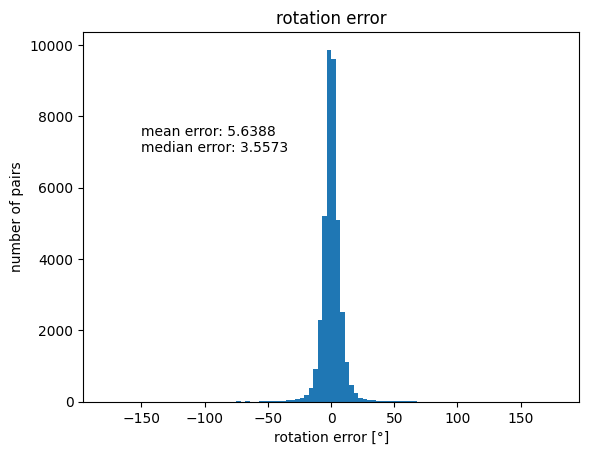

In [26]:
plt.hist(rotation_error, bins=100)
plt.title("rotation error")
text = f"mean error: {np.mean(abs(np.array(rotation_error))):.4f}\nmedian error: {np.median(abs(np.array(rotation_error))):.4f}"
plt.text(-150, 7000, s=text)
plt.xlabel("rotation error [°]")
plt.ylabel("number of pairs")
plt.show()